In [2]:
import numpy as np

array([4, 2, 0, 1, 5, 3])

In [72]:
filename = '/Users/enjlife/machine-learning/machinelearninginaction/ch08/ex0.txt'
filename1 = '/Users/enjlife/machine-learning/machinelearninginaction/ch08/abalone.txt'

In [3]:
def loaddata(filename):
    data = []
    label = []
    with open(filename) as fr:
        for line in fr.readlines():
            arr = line.strip().split('\t')
            data.append(arr[:-1])
            label.append(float(arr[-1]))
    data = np.array(data).astype(float)
    label = np.expand_dims(np.array(label),axis=1)
    return data,label

线性回归，常规的最小二乘法

In [14]:
def regress(data,label):
    if np.linalg.det(np.dot(data.T,data))==0.0:
        print('the array is singular, cannot do inverse')
        return
    ws = np.dot(np.linalg.inv(np.dot(data.T,data)),np.dot(data.T,label))
    return ws

In [74]:
data,label = loaddata(filename)
data1,label1 = loaddata(filename1)

In [15]:
ws = regress(data,label)

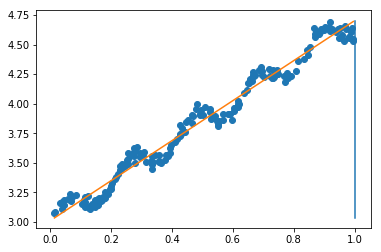

In [31]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(111)
plt.scatter(data[:,1],label)
xcopy = data.copy()
xcopy.sort(0)#按行排序 1按列排序
yhat = np.dot(xcopy,ws)
plt.plot(xcopy,yhat)
plt.show()

In [38]:
yhat = np.dot(data,ws)
np.corrcoef(yhat.T,label.T)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

局部加权线性回归

In [44]:
def lwlr(testpoint,data,label,k=1.0):
    m = data.shape[0]
    weights = np.eye(m)
    for j in range(m):
        diff = testpoint - data[j,:]
        weights[j,j] = np.exp(np.dot(diff,diff.T)/(-2.0*k**2))
    xtx = np.dot(data.T,np.dot(weights,data))
    if np.linalg.det(xtx)==0.0:
        print('the arrat is singular, cannot be inverse')
        return
    ws = np.dot(np.linalg.inv(xtx),np.dot(data.T,np.dot(weights,label)))
    return np.dot(testpoint,ws)

In [52]:
def lwlrtest(testarr,data,label,k=1.0):
    n = testarr.shape[0]
    yhat = np.zeros((n,1))
    for i in range(n):
        yhat[i] = lwlr(testarr[i],data,label,k)
    return yhat

In [87]:
lwlr(data[0],data,label,k=0.001)

array([3.20175729])

In [69]:
yhat = lwlrtest(data,data,label,k=0.01)

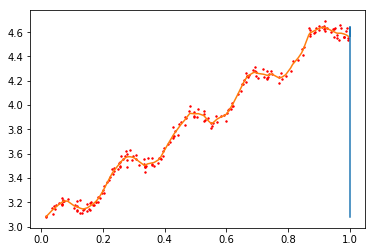

In [70]:
srtind = data[:,1].argsort(0)
xsort = data[srtind]
plt.figure()
plt.subplot(111)
plt.plot(xsort,yhat[srtind])
plt.scatter(data[:,1],label,s=2,c='red')
#plt.axvline(0.8)
plt.show()

In [78]:
print(data1.shape)
print(label1.shape)

(4177, 8)
(4177, 1)


预测鲍鱼的年龄  
1.可以看到预测[0:99]和[100:199]的差别很大,核大小等于10的在[0:99]误差最大，而在[100:199]误差最小

In [82]:
def rsserror(label,yhat):
    return np.sum(np.square(label-yhat))

In [100]:
yhat01 = lwlrtest(data1[100:199],data1[:99],label1[:99],0.1)
yhat1 = lwlrtest(data1[100:199],data1[:99],label1[:99],1)
yhat10 = lwlrtest(data1[100:199],data1[:99],label1[:99],10)

In [101]:
print('{0}\n{1}\n{2}'.format(rsserror(label1[100:199],yhat01),rsserror(label1[100:199],yhat1),rsserror(label1[100:199],yhat10)))

57913.51550155909
573.5261441895273
517.571190538078


In [105]:
#再采用线性回归函数
ws = regress(data1[:99],label1[:99])
yhat = np.dot(data1[100:199],ws)
rsserror(label1[100:199],yhat)

518.6363153245542

当特征数量大于数据量，我们需要缩减特征-第一种方法是岭回归，第二种方法是lasso方法，第三种方法是前向逐步回归

In [116]:
#岭回归
def ridgeregres(data1,label1,l=0.2):
    xtx = np.dot(data1.T,data1)
    denom = xtx + np.eye(data1.shape[1])*l
    if np.linalg.det(denom)==0.0:
        print('the array is singular, cannot do inverse')
        return
    ws = np.dot(np.linalg.inv(denom),np.dot(data1.T,label1))
    return ws

In [117]:
def ridgetest(data,label):
    ymean = np.mean(label)
    label1 = label-ymean
    xmean = np.mean(data,axis=0)
    xvar = np.var(data,axis=0)
    data1 = (data-xmean)/xvar
    num = 30
    w = np.zeros((num,data1.shape[1]))
    for i in range(num):#调试多个lam值
        ws = ridgeregres(data1,label1,np.exp(i-10))
        w[i,:] = ws.T
    return w

In [118]:
ridgew = ridgetest(data1,label1)

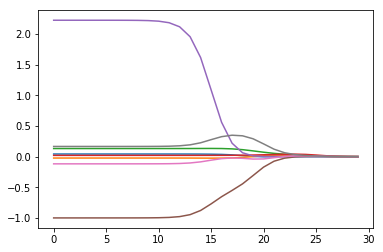

In [124]:
plt.figure()
plt.plot(ridgew)#这里直接输入一个矩阵，代表每一行即每一个lam值生成的权重直线图
#plt.xlim(-10,20)
plt.show()#可以从中间位置找到预测结果最好的lam值

lasso算法将约束条件换为$\sum_{k=1}^{n}{w_k}<=\lambda$.这里我们介绍前向逐步回归来达到与lasso算法类似的效果.  
1.标准化
2.迭代num次，每次迭代n个特征，迭代步长和正反方向
3.保存使误差减小的权重值

In [127]:
#每一步都尽可能减小误差
def stagewise(data,label,eps=0.01,num=100):
    ymean = np.mean(label)
    y = label - ymean
    xmean = np.mean(data,0)
    xvar = np.var(data,0)
    x = (data-xmean)/xvar
    m,n = x.shape
    returnws = np.zeros((num,n))
    ws = np.zeros((n,1))
    wstest = ws.copy()
    wsmax = ws.copy()
    for i in range(num):
        #print(ws.T)
        lowerror = float('inf')
        for j in range(n):
            for sign in [-1.0,1.0]:
                wstest = ws.copy()
                wstest[j] +=eps*sign#迭代每次调整的步长和方向
                ytest = np.dot(x,wstest)
                rss = rsserror(y,ytest)
                if rss < lowerror:
                    lowerror = rss
                    wsmax = wstest
        ws = wsmax.copy()
        returnws[i,:] = ws.T
    return returnws
        

In [130]:
stagewise(data1,label1,0.01,200)#会发现步长过大，在0.04和0.05震荡

[[0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.   0.   0.   0.01 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.02 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.03 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.04 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.05 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.06 0.   0.   0.   0.  ]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.  ]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.01]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.02]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.03]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.04]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.05]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.06]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.07]]
[[0.   0.   0.01 0.06 0.   0.   0.   0.08]]
[[0.   0.   0.01 0.05 0.   0.   0.   0.08]]
[[0.   0.   0.01 0.05 0.   0.   0.   0.09]]
[[0.   0.   0.01 0.05 0.   0.   0.   0.1 ]]
[[0.   0.   0.01 0.05 0.   0.   0.   0.11]]
[[ 0.    0.    0.01  0.05  0.   -0.01  0.    0.11]]
[[ 0.    0.    0.01  0.05  0.   -0.02  0.    0.11]]
[[ 0.    0.    0.01  0.05  0.   

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

In [137]:
returnws = stagewise(data1,label1,0.001,5000)

[[0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.    0.    0.    0.001 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.002 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.003 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.004 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.005 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.006 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.007 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.008 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.009 0.    0.    0.    0.   ]]
[[0.   0.   0.   0.01 0.   0.   0.   0.  ]]
[[0.    0.    0.    0.011 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.012 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.013 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.014 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.015 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.016 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.017 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.018 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.019 0.    0.    0.    

[[ 0.     0.     0.005  0.045  0.    -0.042  0.     0.151]]
[[ 0.     0.     0.005  0.045  0.    -0.043  0.     0.151]]
[[ 0.     0.     0.005  0.045  0.    -0.043  0.     0.152]]
[[ 0.     0.     0.005  0.045  0.    -0.044  0.     0.152]]
[[ 0.     0.     0.005  0.045  0.    -0.045  0.     0.152]]
[[ 0.     0.     0.005  0.045  0.    -0.045  0.     0.153]]
[[ 0.     0.     0.005  0.045  0.    -0.046  0.     0.153]]
[[ 0.     0.     0.005  0.045  0.    -0.046  0.     0.154]]
[[ 0.     0.     0.005  0.045  0.    -0.047  0.     0.154]]
[[ 0.     0.     0.005  0.045  0.    -0.048  0.     0.154]]
[[ 0.     0.     0.005  0.045  0.    -0.048  0.     0.155]]
[[ 0.     0.     0.005  0.045  0.    -0.049  0.     0.155]]
[[ 0.     0.     0.005  0.045  0.    -0.05   0.     0.155]]
[[ 0.     0.     0.005  0.045  0.    -0.05   0.     0.156]]
[[ 0.     0.     0.005  0.045  0.    -0.051  0.     0.156]]
[[ 0.     0.     0.005  0.045  0.    -0.051  0.     0.157]]
[[ 0.     0.     0.005  0.045  0.    -0.

[[ 0.     0.     0.011  0.041  0.    -0.155  0.     0.223]]
[[ 0.     0.     0.011  0.041  0.    -0.156  0.     0.223]]
[[ 0.     0.     0.011  0.041  0.    -0.156  0.     0.224]]
[[ 0.     0.     0.011  0.041  0.    -0.157  0.     0.224]]
[[ 0.     0.     0.011  0.041  0.    -0.158  0.     0.224]]
[[ 0.     0.     0.012  0.041  0.    -0.158  0.     0.224]]
[[ 0.     0.     0.012  0.041  0.    -0.159  0.     0.224]]
[[ 0.     0.     0.012  0.041  0.    -0.16   0.     0.224]]
[[ 0.     0.     0.012  0.041  0.    -0.16   0.     0.225]]
[[ 0.     0.     0.012  0.041  0.    -0.161  0.     0.225]]
[[ 0.     0.     0.012  0.041  0.    -0.161  0.     0.226]]
[[ 0.     0.     0.012  0.041  0.    -0.162  0.     0.226]]
[[ 0.     0.     0.012  0.041  0.    -0.163  0.     0.226]]
[[ 0.     0.     0.013  0.041  0.    -0.163  0.     0.226]]
[[ 0.     0.     0.013  0.041  0.    -0.164  0.     0.226]]
[[ 0.     0.     0.013  0.041  0.    -0.165  0.     0.226]]
[[ 0.     0.     0.013  0.041  0.    -0.

[[ 0.     0.     0.042  0.036  0.    -0.279  0.     0.272]]
[[ 0.     0.     0.042  0.036  0.    -0.28   0.     0.272]]
[[ 0.     0.     0.042  0.036  0.    -0.281  0.     0.272]]
[[ 0.     0.     0.042  0.036  0.    -0.281  0.     0.273]]
[[ 0.     0.     0.042  0.036  0.    -0.282  0.     0.273]]
[[ 0.     0.     0.042  0.036  0.    -0.282  0.     0.274]]
[[ 0.     0.     0.042  0.035  0.    -0.282  0.     0.274]]
[[ 0.     0.     0.043  0.035  0.    -0.282  0.     0.274]]
[[ 0.     0.     0.044  0.035  0.    -0.282  0.     0.274]]
[[ 0.     0.     0.044  0.035  0.    -0.283  0.     0.274]]
[[ 0.     0.     0.044  0.035  0.    -0.284  0.     0.274]]
[[ 0.     0.     0.044  0.035  0.    -0.284  0.     0.275]]
[[ 0.     0.     0.044  0.035  0.    -0.285  0.     0.275]]
[[ 0.     0.     0.044  0.035  0.    -0.285  0.     0.276]]
[[ 0.     0.     0.044  0.035  0.    -0.286  0.     0.276]]
[[ 0.     0.     0.044  0.035  0.    -0.287  0.     0.276]]
[[ 0.     0.     0.045  0.035  0.    -0.

[[ 0.     0.     0.069  0.031  0.    -0.384  0.     0.313]]
[[ 0.     0.     0.069  0.031  0.    -0.384  0.     0.314]]
[[ 0.     0.     0.069  0.031  0.    -0.385  0.     0.314]]
[[ 0.     0.     0.069  0.031  0.    -0.385  0.     0.315]]
[[ 0.     0.     0.069  0.031  0.    -0.386  0.     0.315]]
[[ 0.     0.     0.069  0.031  0.    -0.387  0.     0.315]]
[[ 0.     0.     0.069  0.031  0.    -0.387  0.     0.316]]
[[ 0.     0.     0.069  0.031  0.    -0.388  0.     0.316]]
[[ 0.     0.     0.069  0.031  0.    -0.389  0.     0.316]]
[[ 0.     0.     0.07   0.031  0.    -0.389  0.     0.316]]
[[ 0.     0.     0.07   0.031  0.    -0.39   0.     0.316]]
[[ 0.     0.     0.07   0.031  0.    -0.391  0.     0.316]]
[[ 0.     0.     0.07   0.031  0.    -0.391  0.     0.317]]
[[ 0.     0.     0.07   0.031  0.    -0.392  0.     0.317]]
[[ 0.     0.     0.07   0.031  0.    -0.392  0.     0.318]]
[[ 0.     0.     0.07   0.03   0.    -0.392  0.     0.318]]
[[ 0.     0.     0.071  0.03   0.    -0.

[[ 0.     0.     0.097  0.026  0.    -0.495  0.     0.358]]
[[ 0.     0.     0.097  0.026  0.    -0.495  0.     0.359]]
[[ 0.     0.     0.097  0.026  0.    -0.496  0.     0.359]]
[[ 0.     0.     0.097  0.026  0.    -0.497  0.     0.359]]
[[ 0.     0.     0.097  0.026  0.    -0.497  0.     0.36 ]]
[[ 0.     0.     0.097  0.026  0.    -0.498  0.     0.36 ]]
[[ 0.     0.     0.097  0.026  0.    -0.499  0.     0.36 ]]
[[ 0.     0.     0.098  0.026  0.    -0.499  0.     0.36 ]]
[[ 0.     0.     0.098  0.025  0.    -0.499  0.     0.36 ]]
[[ 0.     0.     0.099  0.025  0.    -0.499  0.     0.36 ]]
[[ 0.     0.     0.099  0.025  0.    -0.499  0.     0.361]]
[[ 0.     0.     0.099  0.025  0.    -0.5    0.     0.361]]
[[ 0.     0.     0.099  0.025  0.    -0.5    0.     0.362]]
[[ 0.     0.     0.099  0.025  0.    -0.501  0.     0.362]]
[[ 0.     0.     0.099  0.025  0.    -0.502  0.     0.362]]
[[ 0.     0.     0.1    0.025  0.    -0.502  0.     0.362]]
[[ 0.     0.     0.1    0.025  0.    -0.

[[ 0.     0.     0.109  0.023  0.093 -0.575  0.     0.374]]
[[ 0.     0.     0.109  0.023  0.094 -0.575  0.     0.374]]
[[ 0.     0.     0.109  0.023  0.094 -0.575 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.095 -0.575 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.096 -0.575 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.097 -0.575 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.098 -0.575 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.098 -0.576 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.099 -0.576 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.1   -0.576 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.1   -0.577 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.101 -0.577 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.102 -0.577 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.102 -0.578 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.103 -0.578 -0.001  0.374]]
[[ 0.     0.     0.109  0.023  0.104 -0.578 -0.001  0.374]]
[[ 0.001  0.     0.109  0.023  0.104 -0.

[[ 0.006  0.     0.11   0.022  0.231 -0.606 -0.011  0.369]]
[[ 0.006  0.     0.11   0.022  0.231 -0.607 -0.011  0.369]]
[[ 0.006  0.     0.11   0.022  0.232 -0.607 -0.011  0.369]]
[[ 0.006  0.     0.11   0.022  0.233 -0.607 -0.011  0.369]]
[[ 0.006  0.     0.11   0.022  0.234 -0.607 -0.011  0.369]]
[[ 0.006  0.     0.11   0.022  0.234 -0.607 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.235 -0.607 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.236 -0.607 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.237 -0.607 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.237 -0.608 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.238 -0.608 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.239 -0.608 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.239 -0.609 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.24  -0.609 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.241 -0.609 -0.011  0.368]]
[[ 0.006  0.     0.11   0.022  0.241 -0.609 -0.011  0.367]]
[[ 0.006  0.     0.11   0.022  0.242 -0.

[[ 0.009  0.     0.11   0.022  0.385 -0.637 -0.019  0.353]]
[[ 0.009  0.     0.11   0.022  0.386 -0.637 -0.019  0.353]]
[[ 0.009  0.     0.11   0.022  0.387 -0.637 -0.019  0.353]]
[[ 0.009  0.     0.11   0.022  0.387 -0.638 -0.019  0.353]]
[[ 0.009  0.     0.11   0.022  0.388 -0.638 -0.019  0.353]]
[[ 0.009  0.     0.11   0.022  0.389 -0.638 -0.019  0.353]]
[[ 0.01   0.     0.11   0.022  0.389 -0.638 -0.019  0.353]]
[[ 0.01   0.     0.11   0.022  0.39  -0.638 -0.019  0.353]]
[[ 0.01   0.     0.11   0.022  0.39  -0.638 -0.02   0.353]]
[[ 0.01   0.     0.11   0.022  0.391 -0.638 -0.02   0.353]]
[[ 0.01   0.     0.11   0.022  0.392 -0.638 -0.02   0.353]]
[[ 0.01   0.     0.11   0.022  0.393 -0.638 -0.02   0.353]]
[[ 0.01   0.     0.11   0.022  0.394 -0.638 -0.02   0.353]]
[[ 0.01   0.     0.11   0.022  0.394 -0.638 -0.02   0.352]]
[[ 0.01   0.     0.11   0.022  0.395 -0.638 -0.02   0.352]]
[[ 0.01   0.     0.11   0.022  0.396 -0.638 -0.02   0.352]]
[[ 0.01   0.     0.11   0.022  0.397 -0.

[[ 0.014  0.     0.11   0.022  0.599 -0.68  -0.03   0.332]]
[[ 0.014  0.     0.11   0.022  0.599 -0.68  -0.03   0.331]]
[[ 0.014  0.     0.11   0.022  0.6   -0.68  -0.03   0.331]]
[[ 0.014  0.     0.11   0.022  0.601 -0.68  -0.03   0.331]]
[[ 0.014  0.     0.11   0.022  0.602 -0.68  -0.03   0.331]]
[[ 0.014  0.     0.11   0.022  0.603 -0.68  -0.03   0.331]]
[[ 0.014  0.     0.11   0.022  0.603 -0.68  -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.604 -0.68  -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.605 -0.68  -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.606 -0.68  -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.607 -0.68  -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.607 -0.681 -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.608 -0.681 -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.609 -0.681 -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.609 -0.682 -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.61  -0.682 -0.031  0.331]]
[[ 0.014  0.     0.11   0.022  0.611 -0.

[[ 0.017  0.     0.11   0.022  0.737 -0.708 -0.037  0.318]]
[[ 0.017  0.     0.11   0.022  0.738 -0.708 -0.037  0.318]]
[[ 0.017  0.     0.11   0.022  0.738 -0.708 -0.038  0.318]]
[[ 0.017  0.     0.11   0.022  0.739 -0.708 -0.038  0.318]]
[[ 0.017  0.     0.11   0.022  0.74  -0.708 -0.038  0.318]]
[[ 0.017  0.     0.11   0.022  0.741 -0.708 -0.038  0.318]]
[[ 0.017  0.     0.11   0.022  0.742 -0.708 -0.038  0.318]]
[[ 0.017  0.     0.11   0.022  0.742 -0.708 -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.743 -0.708 -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.744 -0.708 -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.745 -0.708 -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.745 -0.709 -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.746 -0.709 -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.747 -0.709 -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.747 -0.71  -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.748 -0.71  -0.038  0.317]]
[[ 0.017  0.     0.11   0.022  0.749 -0.

[[ 0.019  0.     0.11   0.022  0.874 -0.733 -0.045  0.304]]
[[ 0.019  0.     0.11   0.022  0.874 -0.734 -0.045  0.304]]
[[ 0.019  0.     0.11   0.022  0.875 -0.734 -0.045  0.304]]
[[ 0.019  0.     0.11   0.022  0.876 -0.734 -0.045  0.304]]
[[ 0.019  0.     0.11   0.022  0.876 -0.735 -0.045  0.304]]
[[ 0.019  0.     0.11   0.022  0.877 -0.735 -0.045  0.304]]
[[ 0.019  0.     0.11   0.022  0.878 -0.735 -0.045  0.304]]
[[ 0.019  0.     0.11   0.022  0.878 -0.735 -0.045  0.303]]
[[ 0.019  0.     0.11   0.022  0.879 -0.735 -0.045  0.303]]
[[ 0.019  0.     0.11   0.022  0.88  -0.735 -0.045  0.303]]
[[ 0.019  0.     0.11   0.022  0.881 -0.735 -0.045  0.303]]
[[ 0.019  0.     0.11   0.022  0.881 -0.736 -0.045  0.303]]
[[ 0.019  0.     0.11   0.022  0.882 -0.736 -0.045  0.303]]
[[ 0.019  0.     0.11   0.022  0.883 -0.736 -0.045  0.303]]
[[ 0.02   0.     0.11   0.022  0.883 -0.736 -0.045  0.303]]
[[ 0.02   0.     0.11   0.022  0.884 -0.736 -0.045  0.303]]
[[ 0.02   0.     0.11   0.022  0.884 -0.

[[ 0.024  0.     0.11   0.022  1.077 -0.774 -0.056  0.284]]
[[ 0.024  0.     0.11   0.022  1.078 -0.774 -0.056  0.284]]
[[ 0.024  0.     0.11   0.022  1.078 -0.774 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.079 -0.774 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.08  -0.774 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.081 -0.774 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.081 -0.775 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.082 -0.775 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.083 -0.775 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.083 -0.776 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.084 -0.776 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.085 -0.776 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.086 -0.776 -0.056  0.283]]
[[ 0.024  0.     0.11   0.022  1.086 -0.776 -0.056  0.282]]
[[ 0.024  0.     0.11   0.022  1.087 -0.776 -0.056  0.282]]
[[ 0.024  0.     0.11   0.022  1.088 -0.776 -0.056  0.282]]
[[ 0.024  0.     0.11   0.022  1.089 -0.

[[ 0.028  0.     0.11   0.022  1.316 -0.822 -0.068  0.259]]
[[ 0.028  0.     0.11   0.022  1.317 -0.822 -0.068  0.259]]
[[ 0.028  0.     0.11   0.022  1.318 -0.822 -0.068  0.259]]
[[ 0.028  0.     0.11   0.022  1.318 -0.823 -0.068  0.259]]
[[ 0.028  0.     0.11   0.022  1.319 -0.823 -0.068  0.259]]
[[ 0.028  0.     0.11   0.022  1.32  -0.823 -0.068  0.259]]
[[ 0.029  0.     0.11   0.022  1.32  -0.823 -0.068  0.259]]
[[ 0.029  0.     0.11   0.022  1.321 -0.823 -0.068  0.259]]
[[ 0.029  0.     0.11   0.022  1.321 -0.823 -0.069  0.259]]
[[ 0.029  0.     0.11   0.022  1.322 -0.823 -0.069  0.259]]
[[ 0.029  0.     0.11   0.022  1.323 -0.823 -0.069  0.259]]
[[ 0.029  0.     0.11   0.022  1.324 -0.823 -0.069  0.259]]
[[ 0.029  0.     0.11   0.022  1.325 -0.823 -0.069  0.259]]
[[ 0.029  0.     0.11   0.022  1.325 -0.823 -0.069  0.258]]
[[ 0.029  0.     0.11   0.022  1.326 -0.823 -0.069  0.258]]
[[ 0.029  0.     0.11   0.022  1.327 -0.823 -0.069  0.258]]
[[ 0.029  0.     0.11   0.022  1.328 -0.

[[ 0.03   0.     0.11   0.022  1.431 -0.845 -0.074  0.248]]
[[ 0.031  0.     0.11   0.022  1.431 -0.845 -0.074  0.248]]
[[ 0.031  0.     0.11   0.022  1.431 -0.846 -0.074  0.248]]
[[ 0.031  0.     0.11   0.022  1.432 -0.846 -0.074  0.248]]
[[ 0.031  0.     0.11   0.022  1.433 -0.846 -0.074  0.248]]
[[ 0.031  0.     0.11   0.022  1.434 -0.846 -0.074  0.248]]
[[ 0.031  0.     0.11   0.022  1.434 -0.846 -0.074  0.247]]
[[ 0.031  0.     0.11   0.022  1.435 -0.846 -0.074  0.247]]
[[ 0.031  0.     0.11   0.022  1.436 -0.846 -0.074  0.247]]
[[ 0.031  0.     0.11   0.022  1.437 -0.846 -0.074  0.247]]
[[ 0.031  0.     0.11   0.022  1.437 -0.846 -0.075  0.247]]
[[ 0.031  0.     0.111  0.022  1.437 -0.846 -0.075  0.247]]
[[ 0.031  0.     0.111  0.022  1.437 -0.846 -0.075  0.246]]
[[ 0.031  0.     0.111  0.022  1.438 -0.846 -0.075  0.246]]
[[ 0.031  0.     0.111  0.022  1.439 -0.846 -0.075  0.246]]
[[ 0.031  0.     0.111  0.022  1.44  -0.846 -0.075  0.246]]
[[ 0.031  0.     0.111  0.022  1.44  -0.

[[ 0.033 -0.002  0.112  0.022  1.544 -0.867 -0.08   0.236]]
[[ 0.033 -0.002  0.112  0.022  1.544 -0.868 -0.08   0.236]]
[[ 0.033 -0.002  0.112  0.022  1.545 -0.868 -0.08   0.236]]
[[ 0.033 -0.002  0.112  0.022  1.546 -0.868 -0.08   0.236]]
[[ 0.033 -0.002  0.112  0.022  1.546 -0.869 -0.08   0.236]]
[[ 0.033 -0.002  0.112  0.022  1.547 -0.869 -0.08   0.236]]
[[ 0.033 -0.002  0.112  0.022  1.548 -0.869 -0.08   0.236]]
[[ 0.033 -0.002  0.112  0.022  1.548 -0.869 -0.08   0.235]]
[[ 0.033 -0.002  0.112  0.022  1.549 -0.869 -0.08   0.235]]
[[ 0.033 -0.002  0.112  0.022  1.55  -0.869 -0.08   0.235]]
[[ 0.033 -0.002  0.112  0.022  1.551 -0.869 -0.08   0.235]]
[[ 0.033 -0.002  0.112  0.022  1.552 -0.869 -0.08   0.235]]
[[ 0.033 -0.002  0.112  0.022  1.552 -0.869 -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.553 -0.869 -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.554 -0.869 -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.555 -0.869 -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.556 -0.

[[ 0.036 -0.003  0.113  0.022  1.674 -0.893 -0.087  0.223]]
[[ 0.036 -0.003  0.113  0.022  1.674 -0.893 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.675 -0.893 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.676 -0.893 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.677 -0.893 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.677 -0.894 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.678 -0.894 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.679 -0.894 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.679 -0.895 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.68  -0.895 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.681 -0.895 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.682 -0.895 -0.087  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.682 -0.895 -0.088  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.683 -0.895 -0.088  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.684 -0.895 -0.088  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.685 -0.895 -0.088  0.222]]
[[ 0.036 -0.003  0.113  0.022  1.686 -0.

[[ 0.04  -0.007  0.117  0.022  1.899 -0.937 -0.099  0.199]]
[[ 0.04  -0.007  0.117  0.022  1.899 -0.938 -0.099  0.199]]
[[ 0.04  -0.007  0.117  0.022  1.9   -0.938 -0.099  0.199]]
[[ 0.04  -0.007  0.117  0.022  1.901 -0.938 -0.099  0.199]]
[[ 0.04  -0.007  0.117  0.022  1.901 -0.939 -0.099  0.199]]
[[ 0.04  -0.007  0.117  0.022  1.902 -0.939 -0.099  0.199]]
[[ 0.04  -0.007  0.117  0.022  1.903 -0.939 -0.099  0.199]]
[[ 0.041 -0.007  0.117  0.022  1.903 -0.939 -0.099  0.199]]
[[ 0.041 -0.007  0.117  0.022  1.903 -0.94  -0.099  0.199]]
[[ 0.041 -0.007  0.117  0.022  1.904 -0.94  -0.099  0.199]]
[[ 0.041 -0.007  0.117  0.022  1.905 -0.94  -0.099  0.199]]
[[ 0.041 -0.007  0.117  0.022  1.906 -0.94  -0.099  0.199]]
[[ 0.041 -0.007  0.117  0.022  1.906 -0.94  -0.099  0.198]]
[[ 0.041 -0.007  0.117  0.022  1.907 -0.94  -0.099  0.198]]
[[ 0.041 -0.007  0.117  0.022  1.908 -0.94  -0.099  0.198]]
[[ 0.041 -0.007  0.117  0.022  1.909 -0.94  -0.099  0.198]]
[[ 0.041 -0.007  0.117  0.022  1.909 -0.

[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.

[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.

[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.

[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.

[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.

[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.

In [131]:
def regularize(data,label):
    ymean = np.mean(label)
    y = label - ymean
    xmean = np.mean(data,0)
    xvar = np.var(data,0)
    x = (data-xmean)/xvar
    return x,y

In [132]:
x,y = regularize(data1,label1)

In [133]:
weights = regress(x,y)#这里运行后发现5000次与常规的最小二乘法类似

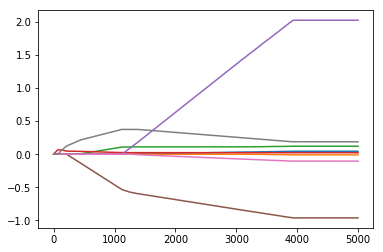

In [138]:
plt.figure()
plt.plot(returnws)
plt.show()

In [148]:
from time import sleep
import json
import urllib.request
#这里api应该已经换了
def searchfs(retx,rety,num,yr,numpce,orig):
    sleep(10)
    api = 'get from code.google.com'
    searchurl = 'http://www.googleapis.com/shopping/search/v1/public/product?/key=%s&country=US&q=lego+%d&alt=json' %(api,num)
    pg = urllib.request.urlopen(searchurl)
    retdict = json.loads(pg.read())
    for i in range(len(retdict['items'])):
        try:
            cur = retdict['items'][i]
            if cur['product']['condition'] == 'new':
                newflag = 1
            else:
                newflag = 0
            listofinv = cur['product']['inventories']
            for item in listofinv:
                price = item['price']
                if price > orig*0.5:
                    print('%d\t%d\t%d\t%f\t%f' %(yr,num,newflag,orig,price))
                    retx.append([yr,num,newflag,orig])
                    rety.append(price)
        except: print('problem with item %d' %i)
    return retx,rety
def setcollect(retx,rety):
    searchfs(retx,rety,8288,2006,800,49.99)
    searchfs(retx,rety,10030,2002,3096,269.99)
    return retx,rety    

In [149]:
retx = []
rety = []
retx,rety = setcollect(retx,rety)

ConnectionResetError: [Errno 54] Connection reset by peer

In [ ]:
#交叉验证测试岭回归
def crossva(xarr,yarr,num=10):
    m = len(yarr)
    indexlist = list(range(m))
    error = np.zeros((num,30))
    for i in range(num):
        trainx = []
        trainy = []
        testx = []
        testy = []
        np.random.shuffle(indexlist)
        for j in range(m):
            if j < 0.9*m:
                trainx.append(xarr[j])
                trainy.append(yarr[j])
            else:
                tsetx.append(xarr[indexlist[j]])
                testy.append(yarr[indexlist[j]])
        trainx = np.array(trainx)
        trainy = np.expand_dims(np.array(trainy))
        testx = np.array(testx)
        testy = np.expand_dims(np.array(testy))
        ws = ridgetest(trainx,trainy)
        for k in range(30):
            meanx = np.mean(trainx)
            varx = np.var(trianx)
            testx = (testx-meanx)/varx
            yest = np.dot(testx,ws[k].T) + np.mean(trainy)
            error[i,j] = rsserror(yest,testy)
        meanerror = np.mean(error,axis=0)
        minmean = float(min(meanerror))
        weights = np.array([np.nonzero(meanerror==minerror)])
        meanx = np.mean(xarr,axis=0)
        varx = np.var(xarr,axis=0)
        unreg = weights/varx#数据还原，因为最小二乘法没有标准化，为了与之作比较，这里需要还原。
        print('the best model is: ',unreg)
        print('with constant term:',unreg-1*np.sum(np.multiply(meanx,unreg))+np.mean(yarr))#这里的常数项也要转化为未标准化的常数项
        #获取常数项和权重值就可以得出最终的价格公式与最小二乘法作比较

In [158]:
a = np.array([1,2,3,4,5,6,7])
b = np.zeros(a.shape)
b[1] = 1
c = a[b==0]
print(c)
print(b)

[1 3 4 5 6 7]
[0. 1. 0. 0. 0. 0. 0.]


In [155]:
a

array([3, 6, 2, 5, 4, 1, 7])